In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch

# Phân tích mô tả giá cổ phiếu FPT

## 1. Load dữ liệu

In [3]:
fpt_historical_stock_price = pd.read_csv(r'..\..\data\raw\fpt_historical_price.csv', parse_dates=['time'])
fpt_historical_stock_price = fpt_historical_stock_price[fpt_historical_stock_price['time'] > '2019-12-31']
fpt_historical_stock_price

,time,open,high,low,close,volume
3238,2020-01-02,21.28,21.54,21.17,21.39,896720
3239,2020-01-03,21.50,21.57,20.95,21.03,2047880
3240,2020-01-06,20.84,21.03,20.73,20.81,1091660
3241,2020-01-07,20.92,21.21,20.81,21.21,837240
3242,2020-01-08,20.99,21.06,20.73,20.73,1814290
...,...,...,...,...,...,...
4673,2025-10-03,92.20,94.00,92.10,93.40,7681300
4674,2025-10-06,94.30,95.90,93.50,95.50,6580000
4675,2025-10-07,96.00,96.30,95.20,95.50,5997500
4676,2025-10-08,95.50,96.90,94.50,94.50,5132100


In [4]:
fpt_historical_stock_price.describe()

,time,open,high,low,close,volume
count,1440,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03
mean,2022-11-20 22:56:00,61.893236,62.563056,61.239861,61.896062,2.994438e+06
min,2020-01-02 00:00:00,14.780000,15.000000,14.640000,14.750000,2.219660e+05
25%,2021-06-14 18:00:00,42.502500,43.055000,41.970000,42.702500,1.296555e+06
50%,2022-11-17 12:00:00,51.390000,51.910000,50.890000,51.390000,2.109933e+06
75%,2024-05-03 18:00:00,90.975000,93.550000,90.382500,91.350000,3.484163e+06
max,2025-10-09 00:00:00,132.870000,134.500000,132.260000,133.040000,2.351430e+07
std,NaN,32.369055,32.663303,32.047558,32.333324,2.882218e+06


In [5]:
fpt_historical_stock_price


,time,open,high,low,close,volume
3238,2020-01-02,21.28,21.54,21.17,21.39,896720
3239,2020-01-03,21.50,21.57,20.95,21.03,2047880
3240,2020-01-06,20.84,21.03,20.73,20.81,1091660
3241,2020-01-07,20.92,21.21,20.81,21.21,837240
3242,2020-01-08,20.99,21.06,20.73,20.73,1814290
...,...,...,...,...,...,...
4673,2025-10-03,92.20,94.00,92.10,93.40,7681300
4674,2025-10-06,94.30,95.90,93.50,95.50,6580000
4675,2025-10-07,96.00,96.30,95.20,95.50,5997500
4676,2025-10-08,95.50,96.90,94.50,94.50,5132100


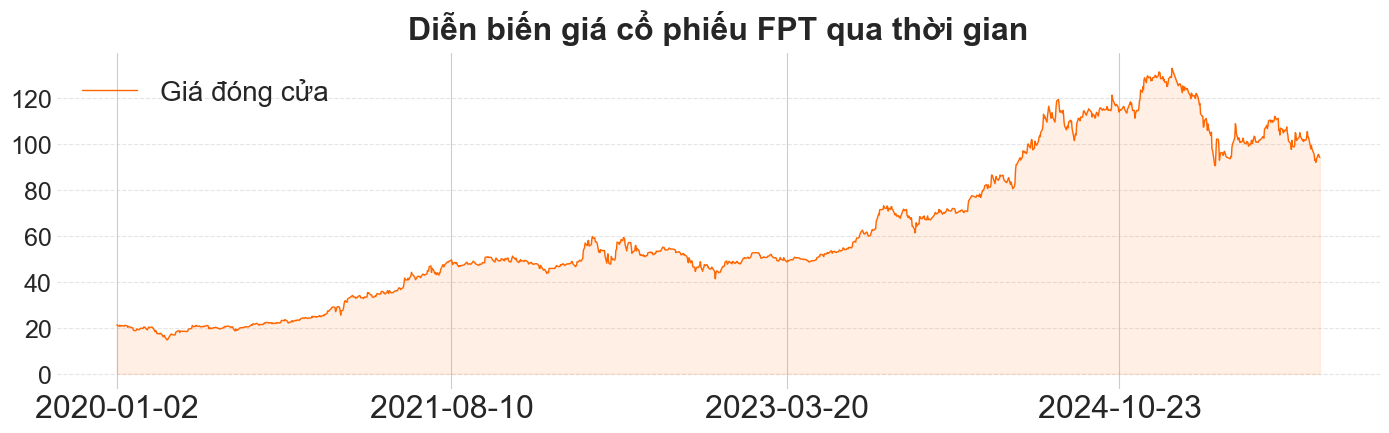

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

# Vẽ đường giá đóng cửa
plt.plot(
    fpt_historical_stock_price['time'],
    fpt_historical_stock_price['close'],
    color='#FF6600', linewidth=1, label='Giá đóng cửa'
)

# Làm nổi bật vùng gần đây
plt.fill_between(
    fpt_historical_stock_price['time'],
    fpt_historical_stock_price['close'],
    color='#FF6600', alpha=0.1
)

# Tùy chỉnh font, trục, grid
# plt.xlabel('Thời gian', fontsize=18, labelpad=5)
# plt.ylabel('Giá đóng (nghìn đồng)', fontsize=18, labelpad=5)
plt.xticks(
    fpt_historical_stock_price['time'][::400],
    rotation=0,
    fontsize=23
)
plt.yticks(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Viền trắng, layout gọn
plt.box(False)
plt.tight_layout()

# Chú thích + Tiêu đề
plt.title('Diễn biến giá cổ phiếu FPT qua thời gian', fontsize=23, fontweight='bold', pad=10)
plt.legend(frameon=False, fontsize=20, loc='upper left')

# Nền trắng sạch để in/chiếu
plt.style.use('seaborn-v0_8-whitegrid')

plt.show()


## 2. Phân tích biến động với GARCH

### 2.1. Chọn bộ tham số (p, q)

In [7]:
# Tính log return nếu chưa có biến returns
returns = (fpt_historical_stock_price['close'].pct_change()).apply(lambda x: np.log(1+x)).dropna()

best_aic = float('inf')
best_order = None

for p in range(1,4):      # thử p từ 1 tới 3
    for q in range(1,4):  # thử q từ 1 tới 3
        model = arch_model(returns, vol='Garch', p=p, q=q)
        garch_res = model.fit(disp='off')
        if garch_res.aic < best_aic:
            best_aic = garch_res.aic
            best_order = (p,q)

print("Best GARCH(p,q) by AIC:", best_order)

Best GARCH(p,q) by AIC: (2, 3)


### 2.2. Tiến hành phân tích với GARCH

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3855.79
Distribution:                  Normal   AIC:                          -7703.58
Method:            Maximum Likelihood   BIC:                          -7682.49
                                        No. Observations:                 1439
Date:                Sun, Oct 19 2025   Df Residuals:                     1438
Time:                        16:39:11   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0926e-03  2.970e-05     36.783 3.400e-296 [1.

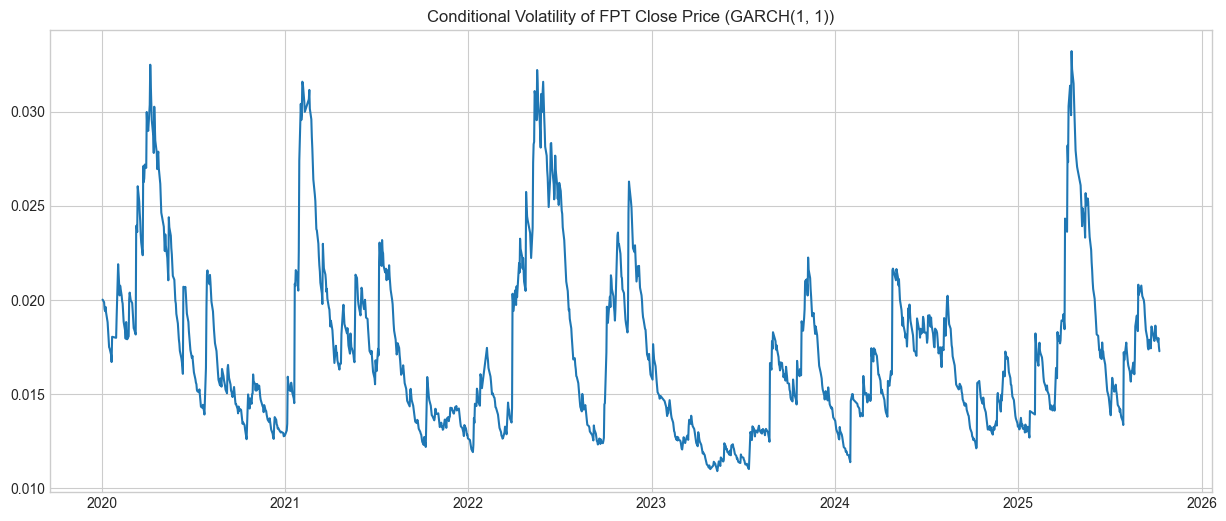

In [8]:
P, Q = (1, 1)
# Fit GARCH(1,1)
garch_model = arch_model(returns, vol='Garch', p=P, q=Q)
garch_res = garch_model.fit(disp='off')

print(garch_res.summary())

# Dự báo phương sai có điều kiện
fitted_vol = garch_res.conditional_volatility

# Vẽ
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(fpt_historical_stock_price['time'][1:], fitted_vol)
plt.title(f'Conditional Volatility of FPT Close Price (GARCH({P}, {Q}))')
plt.show()

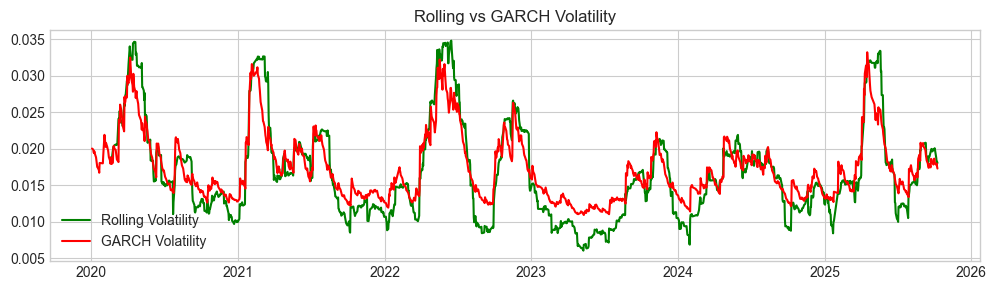

In [9]:
rolling_var = returns.rolling(window=30).std()

# Align time index with rolling_var and fitted_vol (both have same index as returns)
time_aligned = fpt_historical_stock_price['time'].iloc[1:]  # returns, rolling_var, fitted_vol all start from index 1

plt.figure(figsize=(12, 3))
plt.plot(time_aligned, rolling_var, label='Rolling Volatility', color='green')
plt.plot(time_aligned, fitted_vol, label='GARCH Volatility', color='red')
plt.legend()
plt.title('Rolling vs GARCH Volatility')
plt.show()


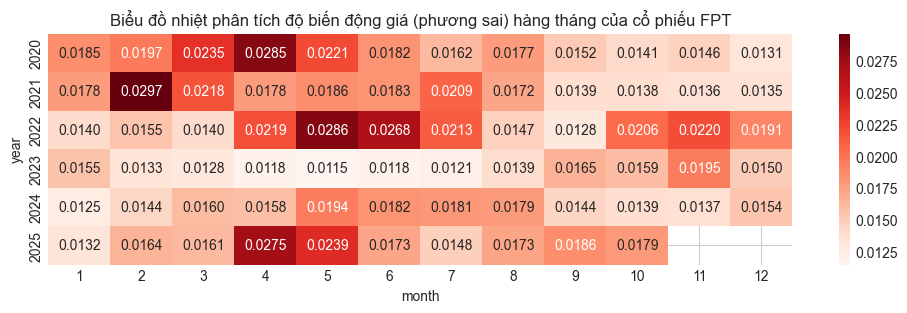

In [10]:
import seaborn as sns

fpt_historical_stock_price['month'] = fpt_historical_stock_price['time'].dt.month
fpt_historical_stock_price['year'] = fpt_historical_stock_price['time'].dt.year
fpt_historical_stock_price['conditional_vol'] = fitted_vol

monthly_vol = fpt_historical_stock_price.groupby(['year','month'])['conditional_vol'].mean().unstack()
plt.figure(figsize=(12, 3))
sns.heatmap(monthly_vol, cmap='Reds', annot=True, fmt=".4f")
plt.title('Biểu đồ nhiệt phân tích độ biến động giá (phương sai) hàng tháng của cổ phiếu FPT')
plt.show()


### 2.3. Dự báo với GARCH

In [11]:
n_forecast = 30

# Lấy dự báo cho phương sai (variance)
garch_forecast = garch_res.forecast(horizon=n_forecast)

# Chuyển đổi từ phương sai sang độ lệch chuẩn (volatility) để dễ diễn giải hơn
forecast_vol = np.sqrt(garch_forecast.variance.values[-1, :])

print("\n--- Dự báo biến động (độ lệch chuẩn) cho 30 ngày tới ---")
print(forecast_vol)


--- Dự báo biến động (độ lệch chuẩn) cho 30 ngày tới ---
[0.01686703 0.0168859  0.01690437 0.01692245 0.01694015 0.01695748
 0.01697444 0.01699105 0.01700732 0.01702324 0.01703882 0.01705409
 0.01706903 0.01708366 0.01709799 0.01711202 0.01712576 0.01713921
 0.01715239 0.01716529 0.01717792 0.01719029 0.01720241 0.01721427
 0.01722589 0.01723727 0.01724841 0.01725933 0.01727002 0.01728049]


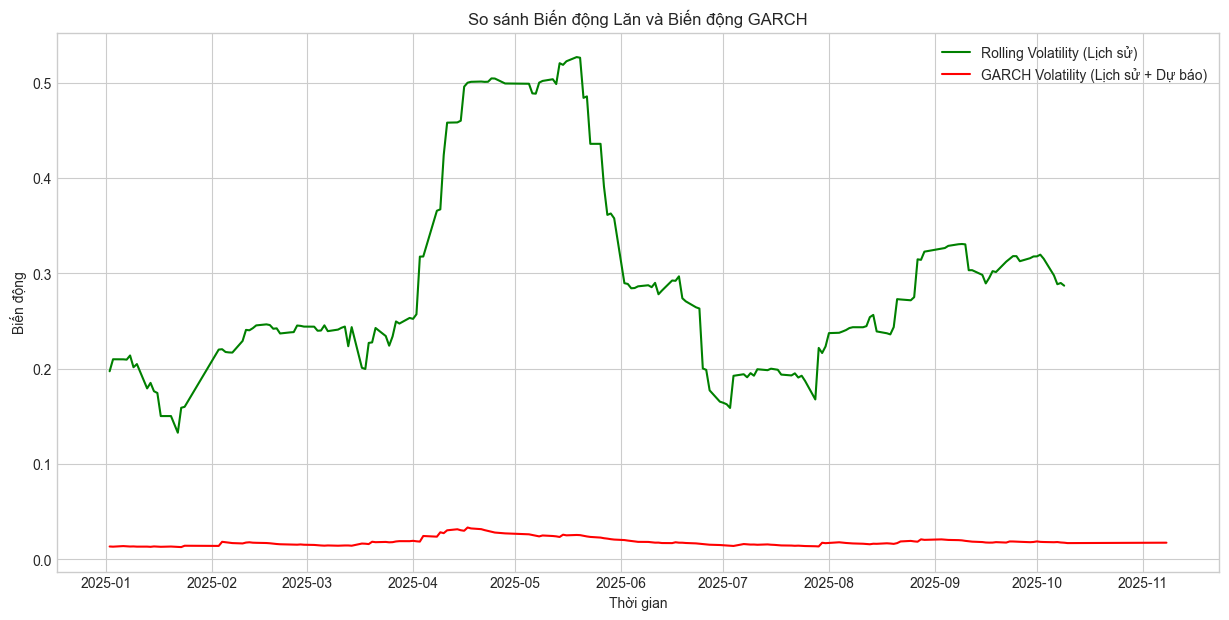

In [12]:
data = fpt_historical_stock_price.copy()

# 1. Chuyển đổi cột 'time' thành kiểu datetime (Quan trọng nhất!)
data['time'] = pd.to_datetime(data['time'])

# 2. Đặt cột 'time' làm index. BÂY GIỜ CHÚNG TA CÓ 1 DATETIMEINDEX ĐÚNG CHUẨN
data = data.sort_values('time').set_index('time')


# --- BƯỚC 1: TÍNH TOÁN DỮ LIỆU CẦN THIẾT (Sử dụng dataframe 'data' đã chuẩn hóa) ---
# fitted_vol và rolling_var phải được tính toán lại từ 'data' để đảm bảo index khớp

# Giả sử bạn tính rolling_var với cửa sổ 30 ngày
rolling_var = data['close'].pct_change().rolling(window=30).std() * np.sqrt(252) # Ví dụ
rolling_var = rolling_var.dropna()

# Lấy fitted_vol từ kết quả GARCH (garch_res.conditional_volatility)
# và gán cho nó index đúng từ 'data'
fitted_vol = garch_res.conditional_volatility
fitted_vol.index = data.index[-len(fitted_vol):] # Đồng bộ index


# --- BƯỚC 2: TẠO DỰ BÁO VÀ TRỤC THỜI GIAN TƯƠNG LAI ---

# Lấy ngày cuối cùng từ index ĐÃ ĐƯỢC CHUẨN HÓA của 'data'
last_date = data.index[-1]

# Tạo ra chuỗi ngày cho tương lai (sẽ hoạt động vì last_date là Timestamp)
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast)

# Chuyển mảng dự báo thành một Pandas Series có trục thời gian tương ứng
forecast_vol_series = pd.Series(forecast_vol, index=forecast_dates)


# --- BƯỚC 3: NỐI DỮ LIỆU VÀ VẼ ĐỒ THỊ ---

# Nối chuỗi lịch sử và chuỗi dự báo
full_garch_vol = pd.concat([fitted_vol, forecast_vol_series])

# Vẽ đồ thị
plt.figure(figsize=(15, 7))

# Lọc và vẽ. Bây giờ thao tác lọc trên .index sẽ hoạt động chính xác
plt.plot(rolling_var[rolling_var.index > '2025-01-01'], label='Rolling Volatility (Lịch sử)', color='green')
plt.plot(full_garch_vol[full_garch_vol.index > '2025-01-01'], label='GARCH Volatility (Lịch sử + Dự báo)', color='red')

plt.title('So sánh Biến động Lăn và Biến động GARCH')
plt.xlabel('Thời gian')
plt.ylabel('Biến động')
plt.legend()
plt.grid(True)
plt.show()

## 3. Phân tích giá với ARIMA

### 3.1. Tìm tham số (p, d, q) cho mô hình ARIMA

In [13]:
data = fpt_historical_stock_price.copy()
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time').set_index('time')

# Tính toán log return
data['return'] = (data['close'].pct_change()).apply(lambda x: np.log(1+x))
returns = data['return'].dropna()

--- Kết quả kiểm định ADF ---
ADF Statistic: -23.32005911202647
p-value: 0.0
Kết luận: Chuỗi đã dừng (p <= 0.05). Chọn d = 0.

--- Vẽ biểu đồ ACF và PACF để xác định p, q ---


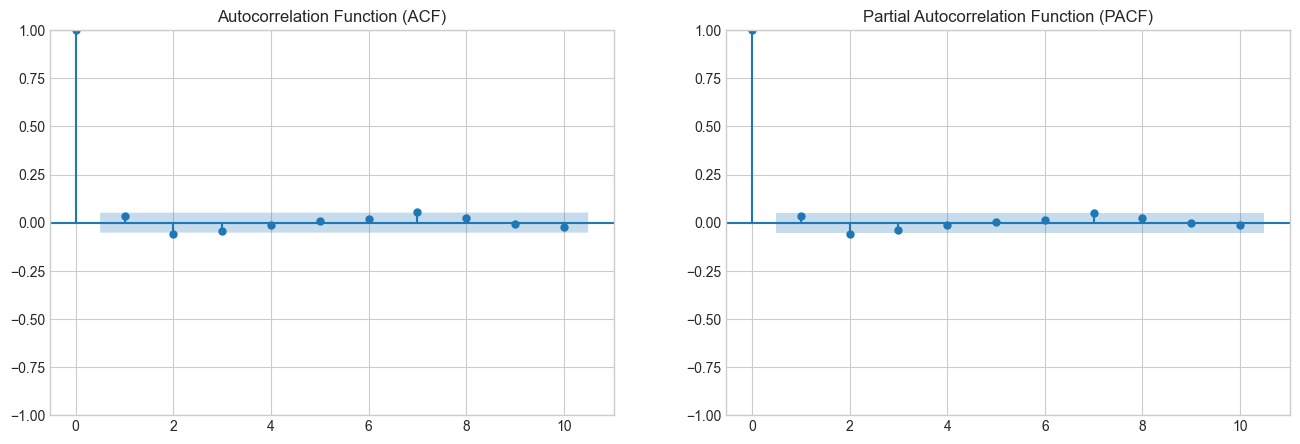

In [14]:
from statsmodels.tsa.stattools import adfuller
# --- BƯỚC 1: TÌM d BẰNG ADF TEST ---
print("--- Kết quả kiểm định ADF ---")
adf_test = adfuller(returns)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
if adf_test[1] <= 0.05:
    print("Kết luận: Chuỗi đã dừng (p <= 0.05). Chọn d = 0.")
else:
    print("Kết luận: Chuỗi không dừng (p > 0.05). Cần sai phân, thử d = 1.")

# --- BƯỚC 2: TÌM p VÀ q BẰNG BIỂU ĐỒ ---
print("\n--- Vẽ biểu đồ ACF và PACF để xác định p, q ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(returns, ax=axes[0], lags=10)
plot_pacf(returns, ax=axes[1], lags=10)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

Vậy `(p, d, q)` = `(0, 0, 0)`.

### 3.2. Xây dựng mô hình ARIMA

In [15]:
p, d, q = 0, 0, 0
arima_model = ARIMA(returns, order=(p, d, q))
arima_results = arima_model.fit()

# In ra bảng tóm tắt để kiểm tra mô hình
print(arima_results.summary())

c:\Users\VICTUS\Documents\developer\UIT_year3_sem1\stock-price-analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\VICTUS\Documents\developer\UIT_year3_sem1\stock-price-analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\VICTUS\Documents\developer\UIT_year3_sem1\stock-price-analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 1439
Model:                          ARIMA   Log Likelihood                3756.433
Date:                Sun, 19 Oct 2025   AIC                          -7508.866
Time:                        16:39:14   BIC                          -7498.322
Sample:                             0   HQIC                         -7504.930
                               - 1439                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.181      0.029       0.000       0.002
sigma2         0.0003   7.33e-06     43.138      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.54   Jarque-

### 3.3. Dự báo dựa vào ARIMA model